<a href="https://colab.research.google.com/github/raksakusumah/Project-Information-Retrieval-/blob/main/ContentBasedFilteringMovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages and dataset

RAKE short for Rapid Automatic Keyword Extraction algorithm, is a domain independent keyword extraction algorithm which tries to determine key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. = https://github.com/csurfer/rake-nltk

In [ ]:
!pip install rake_nltk
import pandas as pd
import numpy as np
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
#tokenizes a collection of words extracted from a text doc
from sklearn.feature_extraction.text import CountVectorizer 
#to evaluate expression whether it is python datatype or not
from ast import literal_eval

In [ ]:
dataset = pd.read_csv('IMDb movies.csv')
print(dataset.shape)
dataset.head()

(85855, 22)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
#convert null value to "Missing Value"
dataset = dataset.fillna('missing value')

We recommend the movie based on movies director and actor movies

In [ ]:
#mov_director = input('Enter the Director name to be recommended: ')
mov_director = 'Joe Russo'
dataset[dataset['director'] == mov_director]

#mov_actor = input('Enter the Actor name to be recommended: ')
mov_actor = 'Chris Evans'
mov_actor = dataset[dataset['actors'].str.contains(mov_actor)] 

Data preprocessing

In [ ]:
dataset.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [ ]:
#extracting relevant columns influencing the ratings based on content
data = dataset[['title','genre','director','actors','description']].head(3000)
data.head()

,title,genre,director,actors,description
0,Miss Jerry,Romance,Alexander Black,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.
1,The Story of the Kelly Gang,"Biography, Crime, Drama",Charles Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...
2,Den sorte drøm,Drama,Urban Gad,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...
3,Cleopatra,"Drama, History",Charles L. Gaskill,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...
4,L'Inferno,"Adventure, Drama, Fantasy","Francesco Bertolini, Adolfo Padovan","Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...


In [ ]:
#convert null value to "Missing Value"
data = data.fillna('missing value')

In [ ]:
#Convert all columns into lower case
data = data.applymap(lambda x: x.lower() if type(x) == str else x)
data.head()

,title,genre,director,actors,description
0,miss jerry,romance,alexander black,"blanche bayliss, william courtenay, chauncey d...",the adventures of a female reporter in the 1890s.
1,the story of the kelly gang,"biography, crime, drama",charles tait,"elizabeth tait, john tait, norman campbell, be...",true story of notorious australian outlaw ned ...
2,den sorte drøm,drama,urban gad,"asta nielsen, valdemar psilander, gunnar helse...",two men of high rank are both wooing the beaut...
3,cleopatra,"drama, history",charles l. gaskill,"helen gardner, pearl sindelar, miss fielding, ...",the fabled queen of egypt's affair with roman ...
4,l'inferno,"adventure, drama, fantasy","francesco bertolini, adolfo padovan","salvatore papa, arturo pirovano, giuseppe de l...",loosely adapted from dante's divine comedy and...


In [ ]:
#Use genre as a list of words
data['genre'] = data['genre'].map(lambda x: x.split(','))
data['genre']

0                            [romance]
1          [biography,  crime,  drama]
2                              [drama]
3                    [drama,  history]
4        [adventure,  drama,  fantasy]
                     ...              
2995      [adventure,  comedy,  crime]
2996    [action,  adventure,  romance]
2997    [action,  adventure,  romance]
2998                           [drama]
2999      [action,  adventure,  crime]
Name: genre, Length: 3000, dtype: object

In [ ]:
#separate names into first and last name with commas
data[['director','actors']] = data[['director','actors']].applymap(lambda x: x.split(',')) #apply map used for more than 1 column, map for 1 column
data[['director','actors']].head()

,director,actors
0,[alexander black],"[blanche bayliss, william courtenay, chaunce..."
1,[charles tait],"[elizabeth tait, john tait, norman campbell,..."
2,[urban gad],"[asta nielsen, valdemar psilander, gunnar he..."
3,[charles l. gaskill],"[helen gardner, pearl sindelar, miss fieldin..."
4,"[francesco bertolini, adolfo padovan]","[salvatore papa, arturo pirovano, giuseppe d..."


In [ ]:
#Combine director, actor names into 1 word respectively, will be used for text extraction
for index,row in data.iterrows():
  row['actors'] = [x.replace(' ','') for x in row['actors']]
  row['director'] = [x.replace(' ','') for x in row['director']]

In [ ]:
#the outcome 'data' column 
data.head()

,title,genre,director,actors,description
0,miss jerry,[romance],[alexanderblack],"[blanchebayliss, williamcourtenay, chaunceydepew]",the adventures of a female reporter in the 1890s.
1,the story of the kelly gang,"[biography, crime, drama]",[charlestait],"[elizabethtait, johntait, normancampbell, bell...",true story of notorious australian outlaw ned ...
2,den sorte drøm,[drama],[urbangad],"[astanielsen, valdemarpsilander, gunnarhelseng...",two men of high rank are both wooing the beaut...
3,cleopatra,"[drama, history]",[charlesl.gaskill],"[helengardner, pearlsindelar, missfielding, mi...",the fabled queen of egypt's affair with roman ...
4,l'inferno,"[adventure, drama, fantasy]","[francescobertolini, adolfopadovan]","[salvatorepapa, arturopirovano, giuseppedeligu...",loosely adapted from dante's divine comedy and...


Keyword Extraction

<b>Keyword extraction is automatic detection of terms that best describe the subject of a document. We will use Rake to extract keywords from description.<b>

In [ ]:
#Create a empty list Keywords
data['keywords'] = ''

In [ ]:
#Loop across all rows to extract all keywords from description
for index, row in data.iterrows():
  description = row['description']
    
  #instantiating Rake by default it uses English stopwords from NLTK and discards all punctuation chars
  r = Rake()
    
  #extract words by passing the text
  r.extract_keywords_from_text(description)
  
  #get the dictionary with key words and their scores
  keyword_dict_scores = r.get_word_degrees()
    
  #assign keywords to new columns
  row['keywords'] = list(keyword_dict_scores.keys())
    
#drop description
data.set_index('title', inplace = True)
data.head()

,genre,director,actors,description,keywords
title,,,,,
miss jerry,[romance],[alexanderblack],"[blanchebayliss, williamcourtenay, chaunceydepew]",the adventures of a female reporter in the 1890s.,"[adventures, female, reporter, 1890s]"
the story of the kelly gang,"[biography, crime, drama]",[charlestait],"[elizabethtait, johntait, normancampbell, bell...",true story of notorious australian outlaw ned ...,"[true, story, 80, )., 1855, notorious, austral..."
den sorte drøm,[drama],[urbangad],"[astanielsen, valdemarpsilander, gunnarhelseng...",two men of high rank are both wooing the beaut...,"[high, rank, famous, equestrian, acrobat, stel..."
cleopatra,"[drama, history]",[charlesl.gaskill],"[helengardner, pearlsindelar, missfielding, mi...",the fabled queen of egypt's affair with roman ...,"[fabled, queen, affair, egypt, ultimately, dis..."
l'inferno,"[adventure, drama, fantasy]","[francescobertolini, adolfopadovan]","[salvatorepapa, arturopirovano, giuseppedeligu...",loosely adapted from dante's divine comedy and...,"[gustav, doré, loosely, adapted, new, score, o..."


Bag of Words

<b>Here the occurence of every word is used as a feature for training a classifier. <b>

In [ ]:
data['BoW'] = ''
columns = data.columns
for index, row in data.iterrows():
  words = ''
  for col in columns:
    words = words + ' '.join(row[col])+ ' '
    row['BoW'] = words

In [ ]:
data.head()

,genre,director,actors,description,keywords,BoW
title,,,,,,
miss jerry,[romance],[alexanderblack],"[blanchebayliss, williamcourtenay, chaunceydepew]",the adventures of a female reporter in the 1890s.,"[adventures, female, reporter, 1890s]",romance alexanderblack blanchebayliss williamc...
the story of the kelly gang,"[biography, crime, drama]",[charlestait],"[elizabethtait, johntait, normancampbell, bell...",true story of notorious australian outlaw ned ...,"[true, story, 80, )., 1855, notorious, austral...",biography crime drama charlestait elizabetht...
den sorte drøm,[drama],[urbangad],"[astanielsen, valdemarpsilander, gunnarhelseng...",two men of high rank are both wooing the beaut...,"[high, rank, famous, equestrian, acrobat, stel...",drama urbangad astanielsen valdemarpsilander g...
cleopatra,"[drama, history]",[charlesl.gaskill],"[helengardner, pearlsindelar, missfielding, mi...",the fabled queen of egypt's affair with roman ...,"[fabled, queen, affair, egypt, ultimately, dis...",drama history charlesl.gaskill helengardner p...
l'inferno,"[adventure, drama, fantasy]","[francescobertolini, adolfopadovan]","[salvatorepapa, arturopirovano, giuseppedeligu...",loosely adapted from dante's divine comedy and...,"[gustav, doré, loosely, adapted, new, score, o...",adventure drama fantasy francescobertolini a...


Count Vectorizer

<b>Count Vectorizer
Convert a collection of text documents to a matrix of token counts. It's a data table that is obtained after normalization of next-generation sequencing data. <b>

In [ ]:
#instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(data['BoW'])

#create a Series for movie titles so they are associated to an ordered numerical list, will use later for match index
indices = pd.Series(data.index)
indices[:5]

#Shape count_matrix
count_matrix
type(count_matrix)

#Convert sparse count_matrix to dense vector
cm = count_matrix.todense()
cm

#Print count_matrix for 0th row
print(count_matrix[0,:]) #This shows all words and their frequency in bow of 0th row

#Gives vocabulary of all words in 'bow' and their counts
count.vocabulary_

  (0, 16901)	1
  (0, 566)	1
  (0, 2192)	1
  (0, 20694)	1
  (0, 3321)	1
  (0, 324)	1
  (0, 6575)	1
  (0, 16407)	1
  (0, 64)	1


{'romance': 16901,
 'alexanderblack': 566,
 'blanchebayliss': 2192,
 'williamcourtenay': 20694,
 'chaunceydepew': 3321,
 'adventures': 324,
 'female': 6575,
 'reporter': 16407,
 '1890s': 64,
 'biography': 2152,
 'crime': 4148,
 'drama': 5153,
 'charlestait': 3269,
 'elizabethtait': 5711,
 'johntait': 10694,
 'normancampbell': 14317,
 'bellacola': 1863,
 'willcoyne': 20656,
 'samcrewes': 17275,
 'jackennis': 9951,
 'johnforde': 10596,
 'veralinden': 19986,
 'mr': 13830,
 'marshall': 12897,
 'mckenzie': 13245,
 'frankmills': 7095,
 'olliewilson': 14538,
 'true': 19583,
 'story': 18437,
 '80': 118,
 '1855': 50,
 'notorious': 14364,
 'australian': 1519,
 'outlaw': 14716,
 'ned': 14054,
 'kelly': 11117,
 'urbangad': 19825,
 'astanielsen': 1426,
 'valdemarpsilander': 19874,
 'gunnarhelsengreen': 8249,
 'emilalbes': 5806,
 'hugoflink': 9331,
 'maryhagen': 12977,
 'high': 9064,
 'rank': 16029,
 'famous': 6454,
 'equestrian': 6000,
 'acrobat': 215,
 'stella': 18357,
 'two': 19652,
 'men': 13310

Calculate Cosine similarity

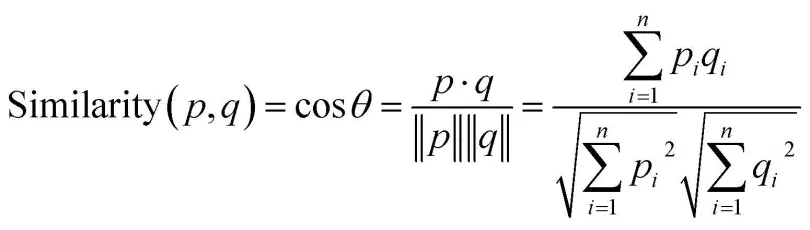

<b>Cosine similarity is a metric used to measure how similar the two items or documents are irrespective of their size. It measures the cosine of an angle between two vectors projected in multi-dimensional space<b>

In [ ]:
#generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.05555556, 0.        ,
        0.        ],
       [0.        , 1.        , 0.03450328, ..., 0.        , 0.03450328,
        0.03333333],
       [0.        , 0.03450328, 1.        , ..., 0.03149704, 0.07142857,
        0.        ],
       ...,
       [0.05555556, 0.        , 0.03149704, ..., 1.        , 0.        ,
        0.06085806],
       [0.        , 0.03450328, 0.07142857, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.03333333, 0.        , ..., 0.06085806, 0.        ,
        1.        ]])

In [ ]:
def recommendations(title,n,cosine_sim = cosine_sim):
  recommended_movies = []
    
  #get index of the movie that matches the title
  idx = indices[indices == title].index[0]
    
  #find highest cosine_sim this title shares with other titles extracted earlier and save it in a Series
  score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
  #get indexes of the 'n' most similar movies
  top_n_indexes = list(score_series.iloc[1:n+1].index)
  print(top_n_indexes)
    
  #populating the list with titles of n matching movie
  for i in top_n_indexes:
    recommended_movies.append(list(data.index)[i])
  return recommended_movies

In [ ]:
# movie = input("Enter the movie name you wished to be recommended similar movies: ").lower()
movie = 'cleopatra'
# n = int(input("How many movies do you want to be recommended: "))
n = 10

In [ ]:
recommendations(movie, n)

[1, 2849, 180, 1650, 2357, 1287, 1908, 2213, 110, 91]


['the story of the kelly gang',
 'tigre verde',
 'victory',
 'dinamite doppia',
 'the crimes of stephen hawke',
 'il dottor jekyll',
 'mrs. wiggs of the cabbage patch',
 'pensione mimosa',
 'tillie wakes up',
 'cleopatra']

In [ ]:
indices[indices == movie].index[0]

3

In [ ]:
pd.Series(cosine_sim[indices[indices == movie].index[0]])

0       0.000000
1       0.275863
2       0.025959
3       1.000000
4       0.025507
          ...   
2995    0.000000
2996    0.000000
2997    0.022893
2998    0.025959
2999    0.000000
Length: 3000, dtype: float64